In [22]:
from tensorflow import cast, float32
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist

import numpy as np
from tensorflow import losses

import matplotlib.pyplot as plt # type: ignore
from sklearn.preprocessing import OneHotEncoder # type: ignore



In [23]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

In [24]:
train_data = train_data / 255.
test_data = test_data / 255.
# Clases pero en palabras para que se vea mas chido
class_names = ['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']


In [25]:
# Queria hacer esto con tensorflow pero preferi hacerlo con
# sklearn porque se me hizo sencillo y aun no entendi bien como
# lo hace tensorflow
enc = OneHotEncoder()

# Train labels
train_labels = train_labels[..., np.newaxis]
transformed = enc.fit_transform(train_labels)
train_labels_encoded = transformed.toarray()

# Test labels
test_labels = test_labels[..., np.newaxis]
transformed = enc.fit_transform(test_labels)
test_labels_encoded = transformed.toarray()

In [26]:
train_data = train_data[..., np.newaxis]
test_data = test_data[..., np.newaxis]

In [27]:
# Guardado de la primer imagen para poder hacer pruebas
eval_image_x = train_data[0:1000, ...]
eval_image_y = train_labels_encoded[0: 1000]

train_data = train_data[1:,...]
train_labels = train_labels[1:,...]
train_labels_encoded = train_labels_encoded[1:,...]

# Creacion de modelo

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Creacion del modelo que funcionara como feature extraction

def get_new_model(input_shape):
    input_layer = Input(shape=input_shape, name='input')
    # Block 1
    h = Conv2D(16, (3,3), activation='relu', padding='same')(input_layer)
    h = Conv2D(16, (3,3), activation='relu', padding='same')(h)
    h = MaxPool2D((2,2))(h)

    # Block 2
    h = Conv2D(32, (3,3), activation='relu', padding='same')(h)
    h = Conv2D(32, (3,3), activation='relu', padding='same')(h)
    h = MaxPool2D((2,2))(h)

    # Block 3
    h = Conv2D(64, (3,3), activation='relu', padding='same')(h)
    h = Conv2D(64, (3,3), activation='relu', padding='same')(h)

    # Embedding
    h = Conv2D(64, (1,1), activation='relu', name='embedding')(h)
    h = Dropout(0.3)(h)

    # FEATURES
    features = GlobalAveragePooling2D(name='features')(h)

    # Classifier
    output = Dense(10, activation='softmax', name='classifier')(features)

    model = Model(inputs=input_layer, outputs=output, name='CNN_GAP')

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


modelT = get_new_model(input_shape=(28,28,1))
modelT.summary()

# Definimos los checkpoints
def get_checkpoint_best_epoch(filepath):
  checkpoint_path = filepath
  checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                               save_weights_only=True,
                               save_best_only=True,
                               save_freq='epoch',
                               monitor='val_accuracy',
                               verbose=0)
  return checkpoint

def get_early_stopping():
  callback = EarlyStopping(monitor='val_accuracy', patience=5)
  return callback


checkpoint_best_epoch = get_checkpoint_best_epoch(f'./checkpoint.weights.h5')
early_stopping = get_early_stopping()

callbacks = [checkpoint_best_epoch, early_stopping]

history_benchmark = modelT.fit(x=train_data,
                                        y=train_labels_encoded,
                                        epochs=5,
                                        batch_size=100,
                                        validation_data=(test_data, test_labels_encoded),
                                        callbacks=callbacks)



Model: "CNN_GAP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Conv2D)              │ (None, 7, 7, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features                        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,602 (299.23 KB)

 Trainable params: 76,602 (299.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.8142 - loss: 0.5452 - val_accuracy: 0.9602 - val_loss: 0.1291
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9621 - loss: 0.1228 - val_accuracy: 0.9776 - val_loss: 0.0709
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9732 - loss: 0.0873 - val_accuracy: 0.9767 - val_loss: 0.0734
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9794 - loss: 0.0684 - val_accuracy: 0.9859 - val_loss: 0.0459
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9825 - loss: 0.0555 - val_accuracy: 0.9873 - val_loss: 0.0381


## Cargamos los pesos del modelo que entrene antes

In [29]:
model = get_new_model(input_shape=(28,28,1))
model.load_weights('./checkpoint.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Modelos
Ahora voy a tomar el modelo que ya cree, con los pesos cargados para crear el feature_extractor y el classifier.

---
### Feature Extractor
El feature extractor lo obtengo "cortando" el modelo en la capa que llame como "features". Además, le dejo el trainable como False para que no se vuelva a hacer.

---
### Classifier
Para el Classifier corte en la capa "classifier", que es un dense de 10 entradas, usa la funcion de activacion softmax

In [30]:
feature_extractor = Model(
    inputs = model.input,
    outputs = model.get_layer("features").output,
    trainable = False
)

In [31]:
classifier = Sequential([
    model.get_layer("classifier")
])
classifier.trainable = False

# Algoritmo Genetico GA

Para hacer el algoritmo genetico GA segui el siguiente diagrama de flujo
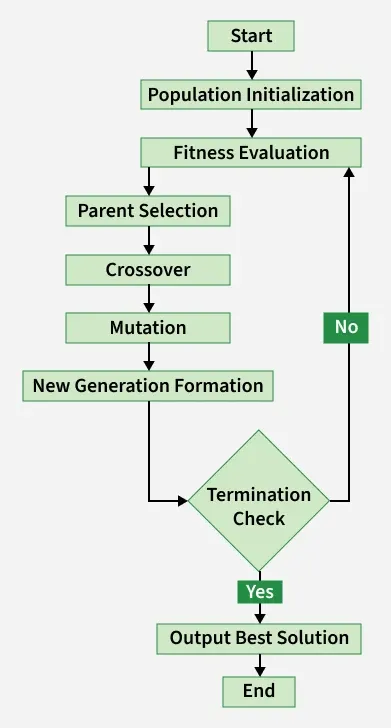

In [41]:
# Mutacion del indivudo seleccionado desde el crossover
def mutate(individual, mutation_prob):
    mutated = individual.copy()

    for gene_idx in range(len(mutated)):
        if np.random.rand() < mutation_prob:
            mutated[gene_idx] = 1 - mutated[gene_idx]

    return mutated

def crossover(parent_a, parent_b):
    gene_mask = np.random.rand(len(parent_a)) < 0.5 
    return np.where(gene_mask, parent_a, parent_b)

# Seleccion de un solo individuo por torneo
def tournament_selecction(population, fitness_scores, tournament_size = 3):
    candidate_indices = np.random.choice(
        len(population),
        size = tournament_size, 
        replace = False
    )

    candidate_fitness = fitness_scores[candidate_indices]
    winner_index = candidate_indices[np.argmin(candidate_fitness)]
    return population[winner_index]

# No se si mi funcion fitness esta bien, pero es lo que saque con lo que pude
# Categorical cross-entropy la agarre porque de acuerdo a google se suele usar cuando se tienen mas de dos clases y tambien porque funciona con softmax
loss_fn = losses.CategoricalCrossentropy()
def fitness(individual, x, y, alpha, beta, classifier_model):
    if individual.sum() == 0:
        return np.inf
    individual_tf = cast(individual, float32)
    
    x_sel = x * individual_tf

    y_pred = classifier_model(x_sel, training=False)

    error = loss_fn(y, y_pred).numpy()
    
    feature_ratio = (individual.sum() / x.shape[1])
    
    return (
        alpha * error
        + beta * feature_ratio
    )


def genetic_algorithm(x, y, classifier_model, pop_size=40, generations=100,
                      crossover_prob = 0.9,
                      mutation_prob = 0.2,
                      alpha=0.1, 
                      beta=0.05):
    best_individual = None
    best_fitness = np.inf
    best_fitness_history = []
    fitness_scores_history = []
    
    num_features = x.shape[1]
    # Inicializamos la poblacion 
    population = np.random.randint(0, 2, size=(pop_size, num_features))
    for generation_idx in range(generations):
        # Fitness Evaluation para toda la poblacion
        fitness_scores = np.array([
            fitness(individual, x, y, alpha, beta, classifier_model) for individual in population 
        ])
        # Seleccionamos el mejor individuo
        best_index_in_population = np.argmin(fitness_scores)
        
        # Si el fitness del mejor individuo es mejor que el best_fitness actual
        if fitness_scores[best_index_in_population] < best_fitness:
        # Actualizamos el mejor fitness y el mejor individuo
            best_fitness = fitness_scores[best_index_in_population]
            best_individual = population[best_index_in_population].copy()
        
        new_population = []

        # Seleccionamos los parents
        if np.random.rand() < 0.5:
            new_population.append(best_individual.copy())
        
        while len(new_population) < pop_size:
            parent_a = tournament_selecction(population, fitness_scores)
            parent_b = tournament_selecction(population, fitness_scores)

            if np.random.rand() < crossover_prob:
                individual = crossover(parent_a, parent_b)
            else:
                individual = parent_a.copy()
            
            individual = mutate(individual, mutation_prob)

            new_population.append(individual)
        population = np.array(new_population)

        print(f"Gen {generation_idx:02d}")
        print(f"Fitness {best_fitness:.4f}")
        print(f"Features  {best_individual.sum()}")
        print(f"Mean cost: {fitness_scores.mean():.4f}")
        print(f"Std cost: {fitness_scores.std():.6f}")
        best_fitness_history.append(best_fitness)
        fitness_scores_history.append(fitness_scores)
    return best_individual, best_fitness, best_fitness_history, fitness_scores_history

    

# Prueba del GA

In [ ]:
# Cracion de x como los features extraidos
x = feature_extractor.predict(test_data)
# Aqui pues hago una copia de las etiquetas que estan encoded
y = test_labels_encoded.copy()
print(classifier.summary())

best_individual, best_fitness, best_fitness_history, fitness_scores_history = genetic_algorithm(x, y, classifier, pop_size=40, generations=100,
                      crossover_prob = 0.7,
                      mutation_prob = 0.3,
                      alpha=1.0, 
                      beta=0.5)


Gen 00
Fitness 0.4195
Features  38
Mean cost: 0.8115
Std cost: 0.318797
Gen 01
Fitness 0.4161
Features  34
Mean cost: 0.6718
Std cost: 0.279418
Gen 02
Fitness 0.4161
Features  34
Mean cost: 0.6535
Std cost: 0.163397
Gen 03
Fitness 0.3840
Features  30
Mean cost: 0.7114
Std cost: 0.205277
Gen 04
Fitness 0.3840
Features  30
Mean cost: 0.7324
Std cost: 0.222005
Gen 05
Fitness 0.3840
Features  30
Mean cost: 0.6624
Std cost: 0.234705
Gen 06
Fitness 0.3840
Features  30
Mean cost: 0.6597
Std cost: 0.221698
Gen 07
Fitness 0.3840
Features  30
Mean cost: 0.6860
Std cost: 0.236745
Gen 08
Fitness 0.3840
Features  30
Mean cost: 0.6950
Std cost: 0.199610
Gen 09
Fitness 0.3840
Features  30
Mean cost: 0.6829
Std cost: 0.209269
Gen 10
Fitness 0.3840
Features  30
Mean cost: 0.6458
Std cost: 0.195313
Gen 11
Fitness 0.3678
Features  34
Mean cost: 0.6360
Std cost: 0.238851
Gen 12
Fitness 0.3678
Features  34
Mean cost: 0.6595
Std cost: 0.219207
Gen 13
Fitness 0.3678
Features  34
Mean cost: 0.6811
Std cost: 0

Features seleccionados: 33
Indices: [ 2  3  8  9 12 13 16 17 19 21 22 23 24 25 26 28 30 31 32 33 36 41 43 44
 49 52 53 55 56 59 60 61 62]


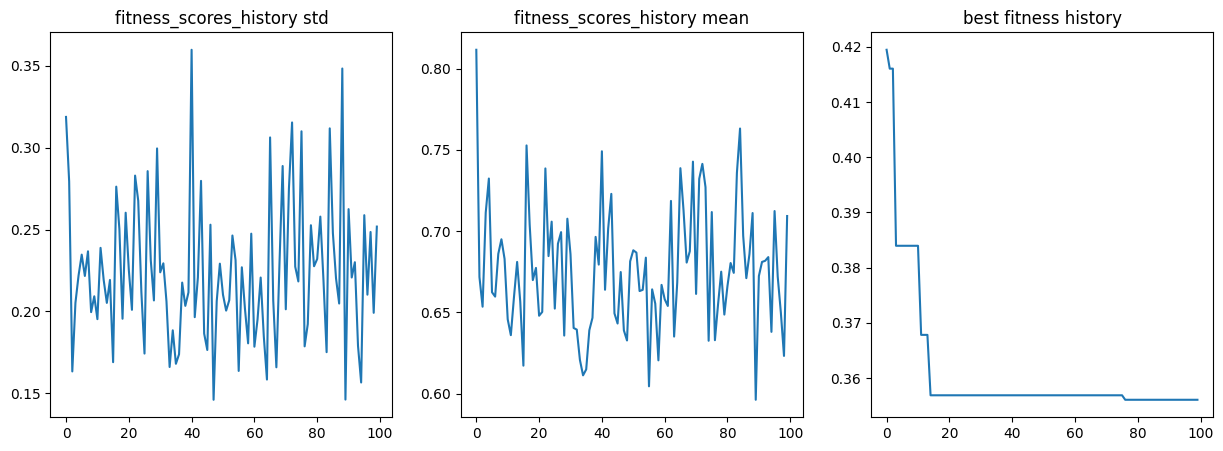

In [71]:
print(f"Features seleccionados:", best_individual.sum())
print(f"Indices:", np.where(best_individual ==1)[0])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].plot([fit.std() for fit in fitness_scores_history])
ax[0].title.set_text('fitness_scores_history std')
ax[1].plot([fit.mean() for fit in fitness_scores_history])
ax[1].title.set_text('fitness_scores_history mean')

ax[2].plot(best_fitness_history)
ax[2].title.set_text('best fitness history')


plt.show()

# Validacion de todo lo que hice

In [72]:
print(eval_image_x.shape)
print(eval_image_y.shape)

# Obtenemos los features de one_image
fe_eval_image_x = feature_extractor.predict(eval_image_x)

# Hacemos feature selection de fe_eval_image_x
individual_tf = cast(best_individual, float32)    
fs_eval_image_x = fe_eval_image_x * individual_tf

# Usamos el classifier para predecir con los features seleccionados de eval_image_x
pred_eval_image_y = classifier.predict(fs_eval_image_x)

(1000, 28, 28, 1)
(1000, 10)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [73]:
y_pred = np.argmax(pred_eval_image_y, axis=1)
y_true = np.argmax(eval_image_y, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.9780
Precision: 0.9787
Recall   : 0.9773
F1-score : 0.9776
